In [16]:
#@title Loading in our data and importing necessary packages
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
data_frame = pd.read_csv("/kaggle/input/brazlilian/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/labels.csv")
data_frame.head()

,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,amd,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,0,1,0,Adequate
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,0,1,0,Adequate
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,0,Adequate
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,0,Adequate


In [18]:
new_data = data_frame[['image_id','hemorrhage']]
new_data.head()

,image_id,hemorrhage
0,img00001,0
1,img00002,0
2,img00003,0
3,img00004,0
4,img00005,0


In [19]:
new_data['hemorrhage'].value_counts()

hemorrhage
0    16170
1       96
Name: count, dtype: int64

In [20]:
# downsampling all classes to lowest count of 2807 X 3 (synthesize 2x copies of minority class)
class0_df = new_data[new_data['hemorrhage'] == 0].sample(n=1000)
class1_df = new_data[new_data['hemorrhage'] == 1]
new_data = pd.concat([class0_df, class1_df])
new_data.shape

(1096, 2)

In [23]:
import shutil
import os
from tqdm import tqdm

# specify directory to move images to
source_directory = "/kaggle/input/brazlilian/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos"
data_dir = "/kaggle/working/images"

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# make class files
num_classes = new_data['hemorrhage'].nunique()
class_directories = {}

for i in range(num_classes):
  class_directory = os.path.join(data_dir, str(i))
  os.makedirs(class_directory, exist_ok=True)
  class_directories[i] = class_directory

for i in tqdm(range(len(new_data))):
  # get filename
  file_name = new_data['image_id'].iloc[i] + ".jpg"
  source = os.path.join(source_directory, file_name)

  # check if file exists
  if os.path.exists(source):
    # check label and move to appropriate directory
    class_label = new_data['hemorrhage'].iloc[i]
    target_directory = class_directories[class_label]

    if class_label == 0:
      shutil.copy(source, target_directory)
    elif class_label == 1:
      shutil.copy(source, target_directory)
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_1.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_2.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_3.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_4.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_5.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_6.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_7.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_8.jpg"))
      shutil.copy(source, os.path.join(target_directory, new_data['image_id'].iloc[i] + "_9.jpg"))

100%|██████████| 1096/1096 [00:03<00:00, 323.68it/s]


In [24]:
import os
for dir in os.listdir(data_dir):
  print(dir, len(os.listdir(os.path.join(data_dir, dir))))

0 1000
1 960


In [26]:
# Data preparation
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define the size of your images and batch size
img_height = 224
img_width = 224
batch_size = 32

if num_classes <= 2:
  label_mode = 'binary'
else:
  label_mode = 'categorical'

# Function to extract labels from the dataset
def get_labels(dataset):
      labels = np.concatenate([y.numpy() for x, y in tqdm(dataset)], axis=0)
      return labels

# Train/test split
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/images',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode=label_mode,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/working/images',
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode=label_mode,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Define the augmentation layer
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.1),
  layers.RandomZoom(0.1),
  layers.RandomHeight(0.1),
  layers.RandomWidth(0.1),
  layers.RandomBrightness(0.1),
  layers.RandomTranslation(0.1, 0.1),
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

AUTOTUNE = tf.data.experimental.AUTOTUNE if hasattr(tf.data, 'experimental') else tf.data.AUTOTUNE

augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create a normalization layer and apply it to the training and validation datasets
normalization_layer = layers.Rescaling(1./255)

normalized_train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 1960 files belonging to 2 classes.
Using 1568 files for training.
Found 1960 files belonging to 2 classes.
Using 392 files for validation.


In [27]:
# Mobilnet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
import datetime

# HYPERPARAMETERS
INPUT_SHAPE = (224, 224, 3)
LR = 4e-5
DROPOUT = .25
TRANSFER_DROPOUT = .25
ALPHA = 1
BATCH_SIZE = 32
NUM_FREEZE = 80
NUM_EPOCHS = 30


def get_lr_metric(optimizer): # used for debugging
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

#Callbacks

# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_recall',  # Monitor validation loss
    patience=4,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# Model Checkpoint callback
model_checkpoint = ModelCheckpoint(
    '/kaggle/working/hemmorage_model3.h5',   # Path where to save the model
    monitor='val_recall',  # Monitor validation loss
    save_best_only=True  # Only save the best model
)


def MobileNet(num_freeze, num_classes, **kwargs):
    base_model = tf.keras.applications.MobileNet(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False, **kwargs)
    for i in range(num_freeze):
      base_model.layers[i].trainable = False

    model= tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(DROPOUT),
        Dense(512, activation='relu'),
        Dropout(DROPOUT),
        Dense(256, activation='relu'),
    ])
    if num_classes <= 2:
        model.add(Dense(1, activation='sigmoid'))
    else:
        model.add(Dense(num_classes, activation='softmax'))
    return model


In [28]:
# Compile the model
model = MobileNet(num_freeze=NUM_FREEZE, num_classes=num_classes, dropout=TRANSFER_DROPOUT, alpha=ALPHA)
optimizer = Adam(learning_rate=LR)
if num_classes <= 2:
    loss = 'binary_crossentropy'
else:
    loss = 'categorical_crossentropy'

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
    ]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)              

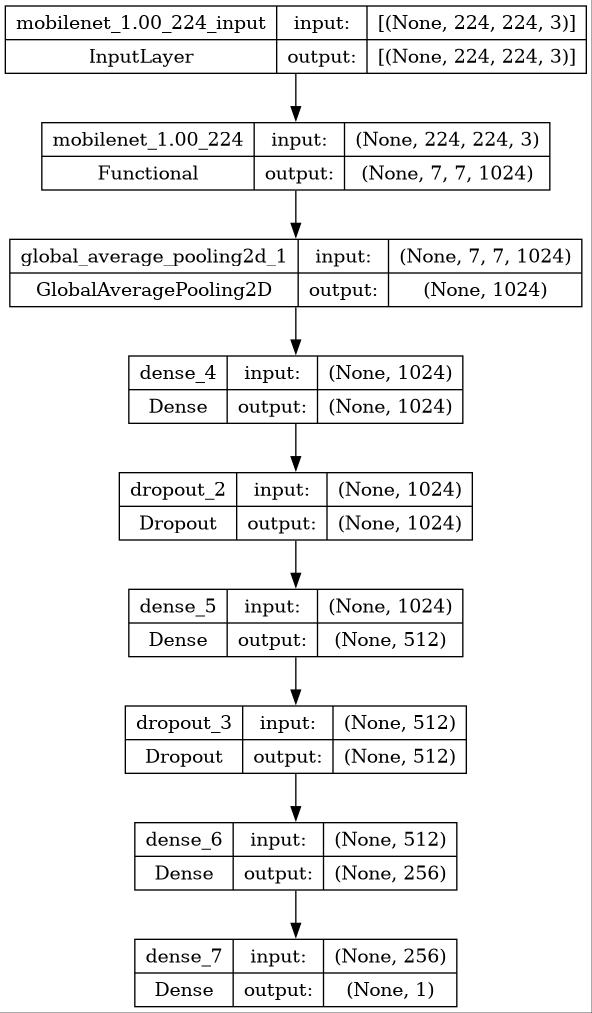

In [29]:
from keras.utils import plot_model
model.summary()
plot_model(model, to_file='model.jpg', show_shapes=True, show_layer_names=True)

In [30]:
# Fit the model with callbacks
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=NUM_EPOCHS,
    verbose=True,
    class_weight=None,
    callbacks=[early_stopping, model_checkpoint,tensorboard_callback]  # Add callbacks here
)

Epoch 1/30
49/49 [==============================] - 52s 855ms/step - loss: 0.6518 - precision_1: 0.6194 - recall_1: 0.6049 - auc_1: 0.6624 - val_loss: 0.6403 - val_precision_1: 0.7179 - val_recall_1: 0.2979 - val_auc_1: 0.7024
Epoch 2/30
49/49 [==============================] - 4s 82ms/step - loss: 0.5401 - precision_1: 0.7195 - recall_1: 0.7111 - auc_1: 0.8109 - val_loss: 0.6210 - val_precision_1: 0.7157 - val_recall_1: 0.3883 - val_auc_1: 0.7435
Epoch 3/30
49/49 [==============================] - 4s 80ms/step - loss: 0.4928 - precision_1: 0.7709 - recall_1: 0.7539 - auc_1: 0.8455 - val_loss: 0.5839 - val_precision_1: 0.7133 - val_recall_1: 0.5691 - val_auc_1: 0.7686
Epoch 4/30
49/49 [==============================] - 4s 81ms/step - loss: 0.4343 - precision_1: 0.8116 - recall_1: 0.7979 - auc_1: 0.8862 - val_loss: 0.5715 - val_precision_1: 0.7184 - val_recall_1: 0.6649 - val_auc_1: 0.7840
Epoch 5/30
49/49 [==============================] - 4s 80ms/step - loss: 0.3927 - precision_1: 0.8

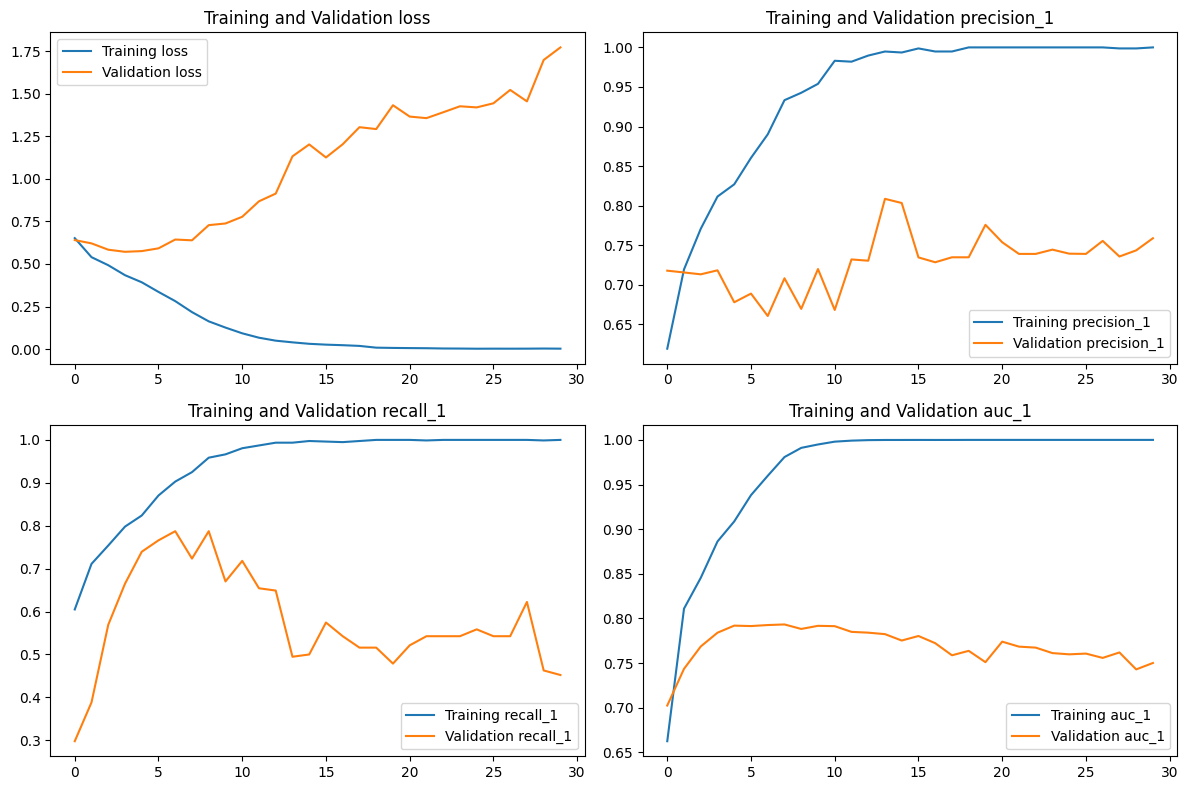

In [31]:
import matplotlib.pyplot as plt

metric_keys = list(history.history.keys())
num_metrics = len(metric_keys) // 2  # Assuming there's a validation metric for each training metric
epochs_range = range(len(history.history[metric_keys[0]]))  # Number of epochs

# Calculate the number of rows needed (each row contains plots for one metric and its validation counterpart)
num_rows = (num_metrics + 1) // 2 if num_metrics % 2 != 0 else num_metrics // 2

plt.figure(figsize=(12, 4 * num_rows))  # Adjust the figure size

for i in range(num_metrics):
    metric = metric_keys[i]
    val_metric = metric_keys[i + num_metrics]  # Validation metric corresponding to the training metric

    plt.subplot(num_rows, 2, i + 1)
    plt.plot(epochs_range, history.history[metric], label=f'Training {metric}')
    plt.plot(epochs_range, history.history[val_metric], label=f'Validation {metric}')
    plt.legend(loc='best')
    plt.title(f'Training and Validation {metric}')

plt.tight_layout()
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 0.4
# Load the model
model = load_model('/kaggle/working/ihemmorage_model3.h5')

# Prepare true labels
y_true = np.concatenate([y for x, y in normalized_val_ds], axis=0)
if num_classes > 2:
  y_true = np.argmax(y_true, axis=1)
# Make predictions
predictions = model.predict(normalized_val_ds)
if num_classes > 2:
  predictions = np.argmax(predictions, axis=1)
predictions = (np.squeeze(predictions) > threshold).astype(int)
disp = ConfusionMatrixDisplay.from_predictions(y_true, predictions)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

# Compute confusion matrix and classification report
#cm = confusion_matrix(y_true, predictions)
#sns.heatmap(cm, annot=True, fmt="d")
#plt.show()

print(classification_report(y_true, predictions))

OSError: No file or directory found at /kaggle/working/hemmorage_model3.h5

In [ ]:
# Test model by supplying various images
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from tensorflow.keras import layers

### Provide inputs
# Pick a raw unmodified image
imgpathroot = '/kaggle/working/1'
# Load previously saved models
model_drprog = '/kaggle/working/hemmorage_model3.h5' 

# Create the DataFrame
data = {'Image': [], 'Act Class': [],'Pred Class': [],'Pred Prob': []}
df = pd.DataFrame(data)

print("Predictions for Class Images")
for dir in os.listdir(imgpathroot):
  imgpath = imgpathroot + '/' + dir
  # Downscale image to fit training resolution
  image = load_img(imgpath, target_size=(224, 224))
  input_image = img_to_array(image)
  input_image = input_image/255 #Normalize to 0-1 range
  input_image = input_image.reshape(1, 224, 224, 3)  # Add batch dimension and match model input shape

  # Load the model
  model = load_model(model_drprog)

  # Make predictions
  predictions = model.predict(input_image)
  #print(predictions)
  predictmax = np.argmax(predictions, axis=1)
  #predictions = (np.squeeze(predictions) > threshold).astype(int)
  predictprob = predictions[0][predictmax] * 100

  #print("Prediction for Image", dir, "is", predictmax[0], "with probability",  predictprob[0],'%')
  # Create a new row
  new_row = {'Image': dir, 'Act Class': '1','Pred Class':predictmax[0], 'Pred Prob':predictprob[0]}
  # Append the new row to the DataFrame
  #df = df.append(new_row, ignore_index=True)
  df = pd.concat([df, new_row], ignore_index=True)

df.to_csv('/kaggle/working//ClassResultshem_1.csv', index=False)
